# Reconstruction over a smaller domain using GraphEM

**Expected time to run through: 10 mins**

This tutorial demonstrates how to get a reconstruction over a smaller domain (30N-70N, 130W-70W) using GraphEM, leveraging HadCRUT4 and the PAGES2k proxy database.

## Test data preparation

To go through this tutorial, please prepare test data following the steps:

Download the test case named “PAGES2k_HadCRUT” with this [link](https://drive.google.com/drive/folders/12V0Ny4eO2HKU40-Iy5Jiw2SAfVNzXXcd?usp=sharing).
Create a directory named “testcases” in the same directory where this notebook sits.
Put the unzipped direcotry “PAGES2k_HadCRUT_cropped_domain” into “testcases”.

Below, we first load some useful packages, including our `GraphEM`.

In [1]:
%load_ext autoreload
%autoreload 2

import LMRt
import GraphEM
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as  plt

## Low-level workflow

In [2]:
job = GraphEM.ReconJob()

In [3]:
job.load_configs('./testcases/PAGES2k_HadCRUT_cropped_domain/configs.yml', verbose=True)

GraphEM: job.load_configs() >>> loading reconstruction configurations from: ./testcases/PAGES2k_HadCRUT_cropped_domain/configs.yml
GraphEM: job.load_configs() >>> job.configs created
GraphEM: job.load_configs() >>> job.configs["job_dirpath"] = /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/recon
GraphEM: job.load_configs() >>> /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/recon created
{'anom_period': [1951, 1980],
 'calib_period': [1930, 2000],
 'job_dirpath': '/Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/recon',
 'job_id': 'GraphEM_tutorial',
 'obs_path': {'tas': './data/obs/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'},
 'obs_varname': {'lat': 'latitude', 'lon': 'longitude', 'tas': 'tas_mean'},
 'proxydb_path': './data/proxy/pages2k_dataset.pkl',
 'ptype_list': ['coral.d18O',
                'coral.SrCa',
                'coral.calc',
                'tree.TRW',


In [4]:
job.load_proxydb(verbose=True)

GraphEM: job.load_proxydb() >>> job.configs["proxydb_path"] = /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/proxy/pages2k_dataset.pkl
GraphEM: job.load_proxydb() >>> 692 records loaded
GraphEM: job.load_proxydb() >>> job.proxydb created


In [11]:
# filter the proxy database by spatial region larger than the target (30N-70N, 130W-70W); using (10N-90N, 150W-60W)
assim_pids = []
for pid, pobj in job.proxydb.records.items():
    if pobj.lat >= 10 and pobj.lat <= 90 and pobj.lon >= np.mod(-150, 360) and pobj.lon <= np.mod(-60, 360):
        assim_pids.append(pid)
        
job.proxydb.filter_pids(assim_pids, inplace=True)
print(job.proxydb)

Proxy Database Overview
-----------------------
     Source:        /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/proxy/pages2k_dataset.pkl
       Size:        111
Proxy types:        {'tree.TRW': 70, 'tree.MXD': 41}


In [12]:
ptype_season = {}
for k, v in job.proxydb.type_dict.items():
    ptype_season[k] = list(range(1, 13)) # annual
    
job.seasonalize_proxydb(ptype_season, verbose=True)
job.filter_proxydb(verbose=True)

GraphEM: job.seasonalize_proxydb() >>> job.configs["ptype_season"] = {'tree.TRW': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
GraphEM: job.seasonalize_proxydb() >>> seasonalizing proxy records according to: {'tree.TRW': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
GraphEM: job.seasonalize_proxydb() >>> 111 records remaining
GraphEM: job.seasonalize_proxydb() >>> job.proxydb updated
GraphEM: job.filter_proxydb() >>> filtering proxy records according to: ['coral.d18O', 'coral.SrCa', 'coral.calc', 'tree.TRW', 'tree.MXD']
GraphEM: job.filter_proxydb() >>> 111 records remaining


In [13]:
job.load_obs(varname_dict={'lat': 'latitude', 'lon': 'longitude', 'tas': 'tas_mean'}, verbose=True)

GraphEM: job.load_obs() >>> loading instrumental observation fields from: {'tas': '/Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/obs/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'}
GraphEM: job.load_obs() >>> job.obs created


In [14]:
job.seasonalize_obs(verbose=True)

GraphEM: job.seasonalize_obs() >>> seasonalized obs w/ season [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/obs/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc
    Shape:  time:171, lat:36, lon:72
GraphEM: job.seasonalize_obs() >>> job.obs updated


/Users/fzhu/Github/LMRt/LMRt/utils.py:261: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(var[inds, ...], axis=0)


## Cropping the domain

In [15]:
print(job.obs)

Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/obs/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc
    Shape:  time:171, lat:36, lon:72


The current domain is global.
We may call the `job.obs.crop()` method with the `domain_range` parameter to crop the domain.

There are two ways of cropping the domain:
+ crop only the latitudes with the input argument `domain_range = [lat_min, lat_max]`
+ crop both the latitudes and longitudes the input argument `domain_range = [lat_min, lat_max, lon_min, lon_max]`

In [16]:
# crop the 30N-70N, 70W-130W region

job.obs.crop([30, 70, np.mod(-130, 360), np.mod(-70, 360)], inplace=True)
print(job.obs)

Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/data/obs/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc
    Shape:  time:171, lat:8, lon:12


## Data preparation

In [17]:
job.prep_data(verbose=True)

GraphEM: job.prep_data() >>> job.recon_time created
GraphEM: job.prep_data() >>> job.calib_time created
GraphEM: job.prep_data() >>> job.calib_idx created
GraphEM: job.prep_data() >>> job.temp created
GraphEM: job.prep_data() >>> job.df_proxy created
GraphEM: job.prep_data() >>> job.proxy created
GraphEM: job.prep_data() >>> job.lonlat created


In [18]:
job.df_proxy

,NAm_153,NAm_165,NAm_046,NAm_193,NAm_194,NAm_188,NAm_156,NAm_154,NAm_122,NAm_186,...,NAm_172,NAm_201,NAm_202,NAm_136,NAm_137,NAm_203,NAm_204,NAm_108,NAm_018,NAm_143
1500,NaN,NaN,1.026,NaN,NaN,0.613,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.764,NaN,0.814,0.901,NaN,0.769,NaN
1501,NaN,NaN,1.058,NaN,NaN,0.592,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.928,NaN,0.946,0.863,NaN,1.060,NaN
1502,NaN,NaN,1.088,NaN,NaN,0.633,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.937,NaN,0.969,0.914,NaN,0.953,NaN
1503,NaN,NaN,0.875,NaN,NaN,0.675,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.775,NaN,1.109,0.927,NaN,1.230,NaN
1504,NaN,NaN,1.139,NaN,NaN,0.882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.834,NaN,1.090,0.838,NaN,1.203,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1.346,NaN,1.373,NaN,NaN,0.823,NaN,1.159,NaN,1.354,...,NaN,NaN,NaN,0.773,0.978,0.648,1.018,NaN,NaN,NaN
1997,NaN,NaN,1.153,NaN,NaN,0.564,NaN,1.358,NaN,1.134,...,NaN,NaN,NaN,0.602,1.017,0.752,0.976,NaN,NaN,NaN
1998,NaN,NaN,1.369,NaN,NaN,0.886,NaN,1.575,NaN,1.368,...,NaN,NaN,NaN,NaN,NaN,0.974,1.029,NaN,NaN,NaN
1999,NaN,NaN,1.502,NaN,NaN,0.798,NaN,1.050,NaN,0.830,...,NaN,NaN,NaN,NaN,NaN,0.702,1.031,NaN,NaN,NaN


In [19]:
print(np.shape(job.temp))
print(np.shape(job.proxy))
print(np.shape(job.lonlat))

(501, 96)
(501, 111)
(207, 2)


In [20]:
job.save(verbose=True)

LMRt: job.save_job() >>> Prepration data saved to: /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/recon/job.pkl
LMRt: job.save_job() >>> job.configs["prep_savepath"] = /Users/fzhu/Github/GraphEM/docsrc/tutorial/testcases/PAGES2k_HadCRUT_cropped_domain/recon/job.pkl


In [21]:
%%time

save_path = './testcases/PAGES2k_HadCRUT_cropped_domain/recon/G.pkl'
job.run_solver(save_path=save_path, verbose=True, distance=1e3, maxit=100)

Estimating graph using neighborhood method
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0386     0.0930
002     0.0959     0.2285
003     0.1653     0.3785
004     0.1087     0.2143
005     0.0851     0.1510
006     0.0792     0.1310
007     0.0694     0.1079
008     0.0585     0.0861
009     0.0493     0.0694
010     0.0429     0.0581
011     0.0385     0.0505
012     0.0356     0.0455
013     0.0351     0.0437
014     0.0330     0.0401
015     0.0317     0.0377
016     0.0306     0.0356
017     0.0294     0.0336
018     0.0283     0.0318
019     0.0273     0.0300
020     0.0262     0.0283
021     0.0252     0.0267
022     0.0242     0.0253
023     0.0232     0.0239
024     0.0223     0.0227
025     0.0215     0.0215
026     0.0207     0.0204
027     0.0199     0.0194
028     0.0192     0.0185
029     0.0186     0.0177
030     0.0212     0.0199
031     0.0190     0.0177
032     0.0196     0.0180
033     0.0183     0.0167
034     0.0186     0.0167
035     0.0163     0.0145
03

In [22]:
np.shape(job.recon)

(501, 8, 12)

In [23]:
job.save_recon(f'./testcases/PAGES2k_HadCRUT_cropped_domain/recon/recon.nc', verbose=True)

LMRt: job.save_recon() >>> Reconstruction saved to: ./testcases/PAGES2k_HadCRUT_cropped_domain/recon/recon.nc


## Validation

In [24]:
with xr.open_dataset('./testcases/PAGES2k_HadCRUT_cropped_domain/recon/recon.nc') as ds:
    print(ds)
    recon = ds['recon']
    lat = ds['lat']
    lon = ds['lon']
    year = ds['year']

<xarray.Dataset>
Dimensions:  (lat: 8, lon: 12, year: 501)
Coordinates:
  * year     (year) int64 1500 1501 1502 1503 1504 ... 1996 1997 1998 1999 2000
  * lat      (lat) float64 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5
  * lon      (lon) float64 232.5 237.5 242.5 247.5 ... 272.5 277.5 282.5 287.5
Data variables:
    recon    (year, lat, lon) float64 ...


In [25]:
mask = (ds['recon'].year>=1850) & (ds['recon'].year<=1930)
tas_recon = ds['recon'].values[mask]
print(np.shape(tas_recon))

(81, 8, 12)


In [26]:
tas_obs = job.obs.fields['tas']
mask = (tas_obs.time>=1850) & (tas_obs.time<=1930)
print(np.shape(tas_obs.value[mask]))

(81, 8, 12)


In [27]:
ce = LMRt.utils.coefficient_efficiency(tas_recon, tas_obs.value[mask])


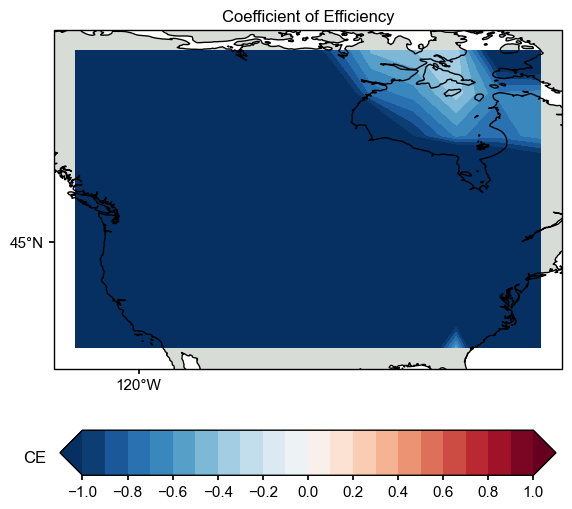

In [28]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
# latlon_range = [0, 360, -90, 90]
latlon_range = [np.mod(-130, 360), np.mod(-70, 360), 30, 70]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']

ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(ds['lon'].values, ds['lat'].values, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title, x=-0.05, y=0.1)

LMRt.showfig(fig)